<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 8: сегментация
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

В рамках семинар обучим U-Net модель отделения предметов от фона на корпусе Pascal VOC.

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision

Установить их можно командой:
```bash
pip3 install --user opencv-python torch torchvision
```

In [1]:
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import VOCSegmentation

import cvmade
import seminar

# Реализация аугментаций с соответствующего семинара.
from augmentations import AffineAugmenter, BrightnessContrastAugmenter, BlurAugmenter, FlipAugmenter, RandomAugmentation

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")
    
# Параметры тренировки и визуализации.
TRAIN = False  # Если False, будут использоваться заранее посчитанные графики
              # вместо реальной тренировки (полезно для демонстрации на ноутбуках без GPU).
TRAIN_KWARGS = {"plot": True,
                "train_plot_kwargs": {"c": "b"},
                "test_scatter_kwargs": {"c": "y", "s": 100, "zorder": 1e10},
                "use_cuda": USE_CUDA}

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.3.1
Use CUDA


# Тренировка Unet на Pascal VOC.

## Подготовка данных

Мы будем использовать корпус Pascal VOC.

In [2]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Mask values: {0, 15, 12, 255}


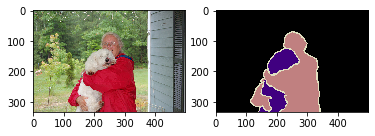

In [3]:
# Создадим временный корпус для просмотра данных.
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=True)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

%matplotlib inline
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

Маска содержит номера классов для каждого пикселя. Имеется две специальные метки: 0 для фона и 255 для контура. Контур мы уберем.

In [4]:
for _ in range(5):
    i = random.randint(0, len(valset_raw) - 1)
    print("Image {:05d} size: {}".format(i, valset_raw[i][0].size))

Image 01391 size: (500, 375)
Image 00765 size: (500, 375)
Image 00294 size: (500, 375)
Image 00404 size: (500, 375)
Image 00831 size: (409, 500)


В корпусе содержатся изображения разного размера. Можно пойти разными путями:
1. привести изображения к одному размеру масштабированием без сохранения пропорций,
2. привести изображения к одному размеру масштабированием с сохранением пропорций,
3. привести изображения к одному размеру, вырезая случайные части,
4. использовать модели, которые могут работать с разными размерами.

Заметим:
* Сеть U-Net способна обрабатывать изображения разных размеров, однако из изображений разного размера нельзя составить однородный тензор батча. Значит, изображения разного размера затруднят тренировку.

* Сеть U-Net является полностью сверточной сетью без паддинга, значит каждый нейрон видит лишь часть картинки и не зависит от положения на изображении и близости к границе.

* Область внимания каждого нейрона задается в пикселях. Значит, чем меньше изображение, тем больше информации о сцене получает каждый нейрон.

Мы воспользуемся вторым вариантом.

При масштабировании изображений с сохранением пропорций и встравивании их в квадратные изображения, образуются пустые области. Пустые области будем заполнять зеркальными отражениями.

In [5]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.
    
    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        # TODO: фикс индексирования для маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

    
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask
    

class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding
        
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter())
        else:
            self._augmenter = lambda image, mask: (image, mask)
        
    @property
    def image_size(self):
        return self._image_size + self._padding * 2
    
    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = cvmade.image.image_to_torch(image).float() - 0.5
        mask = cvmade.image.image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 572 // 2  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 286
Train set size: 2330
Validation set size: 583


Корпус очень маленький.
1. Мы будем учить сеть, состоящую только из сверток. У таких сетей относительно мало параметров и они могут обучаться на небольших корпусах.
2. Каждый пиксель - отдельная метка. Количество пикселей в корпусе огромно, в этом смысле корпус большой.
3. Добавим аугментации

No padding


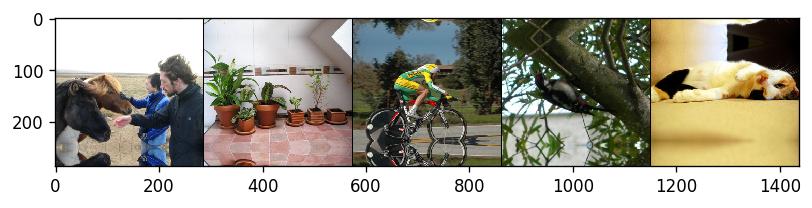

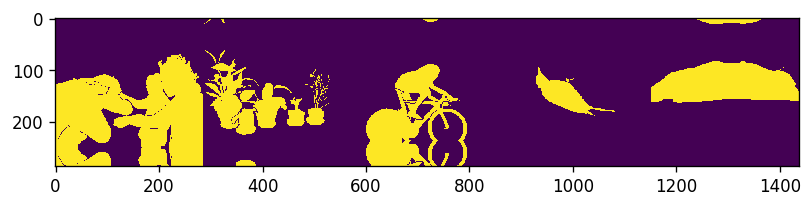

Paddng


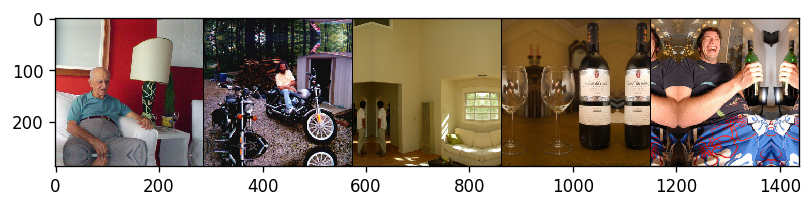

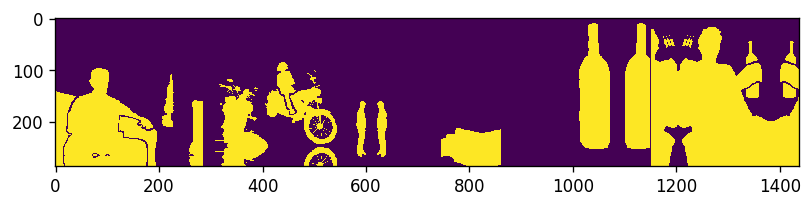

In [6]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(cvmade.image.image_to_numpy(image))
        masks.append(cvmade.image.image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()
    
print("No padding")
valset.set_padding(0)
show_dataset(trainset)
print("Paddng")
valset.set_padding(40)
show_dataset(trainset)
valset.set_padding(0)

## Создание модели

Создадим сеть вида U-Net ( https://arxiv.org/pdf/1505.04597.pdf ).

Сеть U-Net состоит из двух частей. Первая часть строит эмбеддинг. Вторая часть зарисовывает изображение и имеет структуру, похожую на первую часть. Первая часть использует max pooling и сжимает изображение, а вторая разжимает за счет транспонированной свертки. Из-за этого возникает параллель между слоями первой и второй части: они имеют схожий размер тензоров. По этой причине мы можем использовать выходы слоев первой части в качестве входов для слоев второй части. Информация из первой части, в которой сохраняются небольшие детали изображения, без труда используется при зарисовке, что приводит к повыжению детализации маски.

<img src="resources/example-image.jpg" align="left" hspace="20" width="20%" height="20%"/> 
<img src="resources/u-net.jpg" align="left" hspace="20" width="50%" height="50%"/> 
<img src="resources/example-mask.jpg" align="left" hspace="20" width="20%" height="20%"/> 
<div style="clear:both;"></div>

Почему сеть называется U-Net?

Заметьте, что размер выходного тензора меньше, чем размер исходного. В сети не используется паддинг, что позволяет сделать выход независящим от позиции на изображении. В оригинальной статье сеть используется для сегментации больших изображений методом скользящего окна. При этом на границе используется зеркальный padding, размер которого определяется receptive field сети.

<img src="resources/unet-window.jpg" align="left" hspace="20" width="80%" height="80%"/> 
<div style="clear:both;"></div>

Мы внесем несколько изменений в U-Net для ускорения тренировки и повышения качества:
* будем использовать меньший размер изображений и меньший размер сети.
* Добавим residual connections.
* Добавим batch normalization.

Шпаргалка:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

torch.nn.ReLU(inplace=False)

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
```

In [7]:
def make_conv1x1(in_channels, out_channels):
    """Создать слой свертки 1x1."""
    # Начало вашего кода.
    
    layer = ...
    
    # Конец вашего кода.
    
    return layer

def make_transposed_convolution2x2(in_channels, out_channels):
    """Создать транспонированную свертку (AKA deconvolution, upconvolution)."""
    
    # Обратите внимание на параметр output_padding. Поскольку stride в maxpooling
    # может давать один и тот же размер выхода для разных размеров входа, необходимо
    # указать такую добавку к размерности, чтобы получился тензор той же размерности,
    # что и в первой части сети.
    #
    # Поскольку у нас размер изображения всегда четный,
    # output_padding нужно выставить в 0.
    
    # Начало вашего кода.
    
    layer = ...
    
    # Конец вашего кода.
    
    return layer

def make_conv3x3(in_channels, out_channels, bias=True):
    return torch.nn.Conv2d(in_channels, out_channels, 3, bias=bias)

def make_batchnorm(channels):
    return torch.nn.BatchNorm2d(channels)

def make_relu():
    return torch.nn.ReLU(inplace=True)

def make_maxpool2x2():
    return torch.nn.MaxPool2d(2)

seminar.check_conv1x1(make_conv1x1)
seminar.check_t_conv(make_transposed_convolution2x2)
seminar.check_ok()

CHECK OK


In [8]:
class ConvBlock(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu()
        )
        
class ResConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_path = torch.nn.Sequential(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels)
        )
        self.residual_path = make_conv1x1(in_channels, out_channels)
        self.last_relu = make_relu()
        
    def forward(self, x):
        result = self.main_path(x)
        residual = self.residual_path(x)[:, :, 2:-2, 2:-2]
        result = self.last_relu(result + residual)
        return result

In [9]:
# Мы реализуем два класса. Down реализует преобразование между двумя max pooling,
# при этом начинается с max pooling. Первые две свертки сети в него не входят.
# Up реализует преобразование между двумя транспонированными свертками и начинает с
# транспонированной свертки. Последняя свертка сети в него не входит.
#
# Схема модели:
# input -> conv -> conv -> Down x 4 -> Up x 4 -> conv -> output.

class UNetDown(torch.nn.Sequential):
    """Часть сети между двумя max pooling, которая начинается с max pooling."""
    def __init__(self, in_channels, out_channels, block):
        layers = [
            make_maxpool2x2(),
            block(in_channels, out_channels)
        ]
        super().__init__(*layers)
     
    
class UNetUp(torch.nn.Module):
    """Часть сети между двумя транспонированными свертками, которая начинается с
    транспонированной свертки."""
    def __init__(self, in_channels, out_channels, block):
        super().__init__()
        self._transposed_convolution = make_transposed_convolution2x2(in_channels, out_channels)
        self._convolutions = block(out_channels * 2, out_channels)
    
    def forward(self, x_down, x_up):
        x_up = self._transposed_convolution(x_up)
        
        b_down, c_down, h_down, w_down = x_down.shape
        b_up, c_up, h_up, w_up = x_up.shape
        if (h_up > h_down) or (w_up > w_down):
            raise ValueError("Up tensor must be smaller than down tensor")
        offset = ((h_down - h_up) // 2, (w_down - w_up) // 2)
        x_down_cropped = x_down[:, :, offset[0]:offset[0] + h_up, offset[1]:offset[1] + w_up]
        
        x = torch.cat((x_down_cropped, x_up), axis=1)
        result = self._convolutions(x)
        return result


class UNet(torch.nn.Module):
    def __init__(self, num_classes, num_scales=4, base_filters=64, block=ConvBlock):
        """Создать U-Net сеть.
        
        Параметры:
            num_classes: Число классов на выходе. Для классификации объект/фон нужно два класса.
            num_scales: Число блоков U-Net сети, выполняющих изменение размера изображения.
            base_filters: Число фильтров на первом уровне сети.
        """
        super().__init__()
        self._input_convolutions = block(3, base_filters)
        
        layers = []
        filters = base_filters
        for i in range(num_scales):
            layers.append(UNetDown(filters, filters * 2, block))
            filters *= 2
        self._down_layers = torch.nn.Sequential(*layers)
        
        layers = []
        for i in range(num_scales):
            layers.append(UNetUp(filters, filters // 2, block))
            filters //= 2
        self._up_layers = torch.nn.Sequential(*layers)
        
        self._output_convolution = make_conv1x1(filters, num_classes)
        self.initialize_weights()

        # Оценим насколько сеть уменьшает изображение.
        self.eval()
        sample_input = torch.zeros((1, 3, 1000, 1000))
        if USE_CUDA:
            sample_input = sample_input.cuda()
            self.cuda()
        with torch.no_grad():
            sample_output = self(sample_input)
        self.padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2
        
    def forward(self, x):
        down_results = [self._input_convolutions(x)]
        for layer in self._down_layers:
            down_results.append(layer(down_results[-1]))
        x = down_results[-1]
        for i, layer in enumerate(self._up_layers):
            x = layer(down_results[-2 - i], x)
        x = self._output_convolution(x)
        return x
     
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
        
def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total

USE_RESIDUALS = True

unet = UNet(NUM_CLASSES if NUM_CLASSES > 2 else 1,
            num_scales=4,  # Число блоков U-Net сети, в статье 4.
            base_filters=64,  # Размер свертки на первом уровне, в статье 64.
            block=ResConvBlock if USE_RESIDUALS else ConvBlock)

print(unet)
print("Required padding: {}".format(unet.padding))
print("Total parameters: {}".format(count_parameters(unet)))

UNet(
  (_input_convolutions): ResConvBlock(
    (main_path): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (residual_path): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (last_relu): ReLU(inplace=True)
  )
  (_down_layers): Sequential(
    (0): UNetDown(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResConvBlock(
        (main_path): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), 

## Обучение

Создадим класс для подсчета функции потерь - бинарной перекрестной энтропии.

In [10]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

Шпаргалка:

```python
torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)
```

In [11]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Ваш код здесь.
        
        self._bce = ...
        
        # Конец вашего кода.
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))
            
        # predicted: float32, BCHW.
        # masks: long, BHW.
            
        # Ваш код здесь.
        
        loss = ...
        
        # Конец вашего кода.
        
        return loss
        
seminar.check_bce_loss(BCELoss)
seminar.check_ok()

CHECK OK


In [12]:
class XentLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c == 1:
            raise ValueError("{} не подходит для бинарной классификации".format(type(self)))
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [13]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

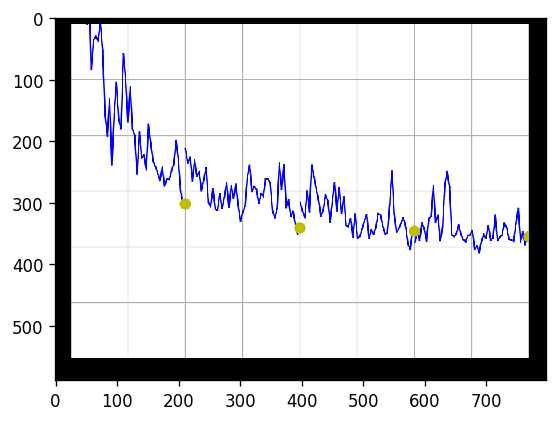

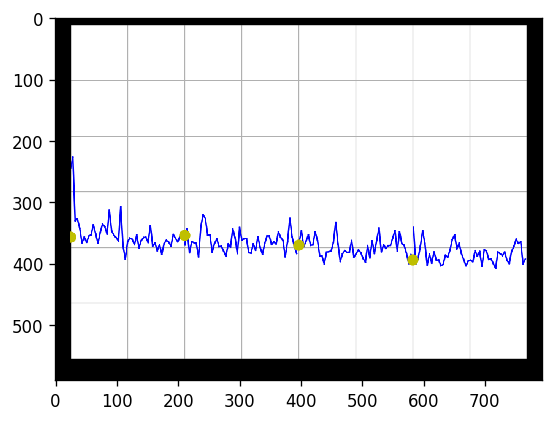

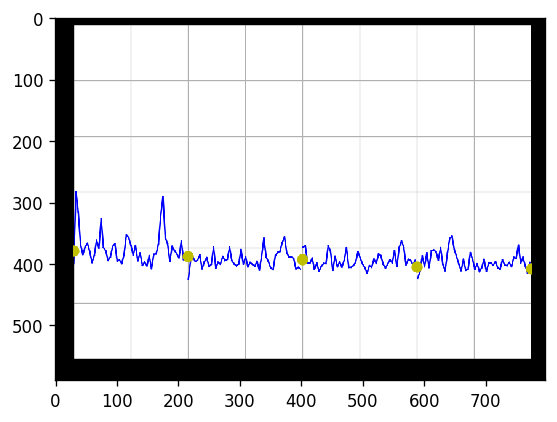

In [14]:
loss_fn = BCELoss if NUM_CLASSES == 2 else XentLoss
unet.load_state_dict(torch.load("checkpoint-noaug.pth.tar"))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    trainset.set_padding(unet.padding)
    valset.set_padding(unet.padding)
    seminar.train_model(unet, loss_fn, make_optimizer, trainset, valset,
                        lr_scheduler_fn=make_lr_scheduler,
                        n_iters=2000,
                        eval_steps=500,
                        batch_size=4,
                        num_workers=8,
                        init=False,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/00-1-noaug.png")
    cvmade.plot.show_image("resources/00-2-noaug.png")
    cvmade.plot.show_image("resources/00-3-noaug.png")

In [15]:
#torch.save(unet.state_dict(), "checkpoint-noaug.pth.tar")

# Show segmentation

Trainset


<Figure size 960x720 with 0 Axes>

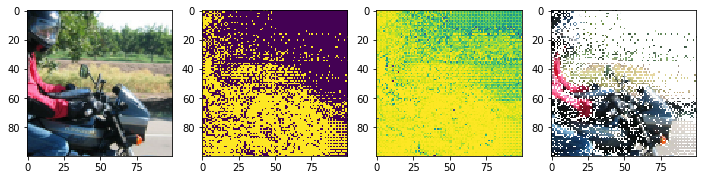

<Figure size 960x720 with 0 Axes>

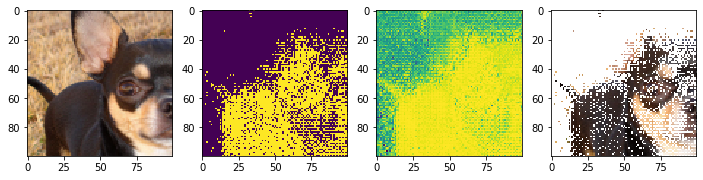

<Figure size 960x720 with 0 Axes>

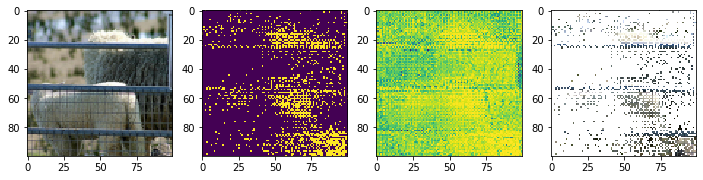

<Figure size 960x720 with 0 Axes>

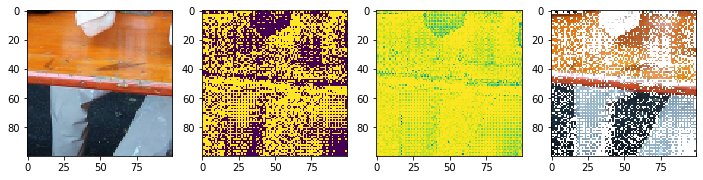

<Figure size 960x720 with 0 Axes>

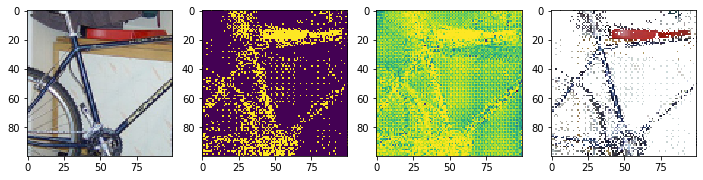

Valset


<Figure size 960x720 with 0 Axes>

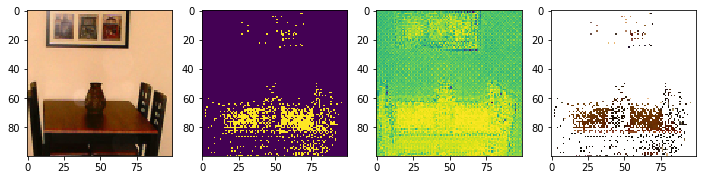

<Figure size 960x720 with 0 Axes>

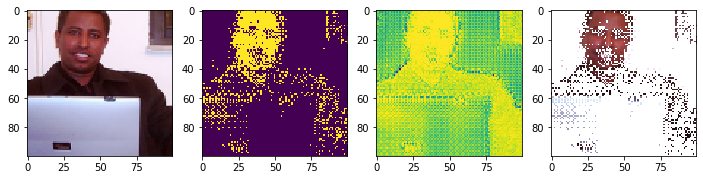

<Figure size 960x720 with 0 Axes>

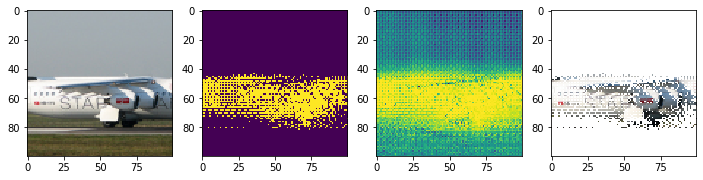

<Figure size 960x720 with 0 Axes>

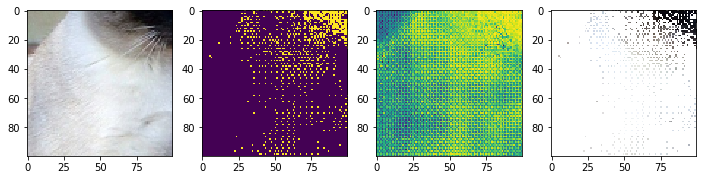

<Figure size 960x720 with 0 Axes>

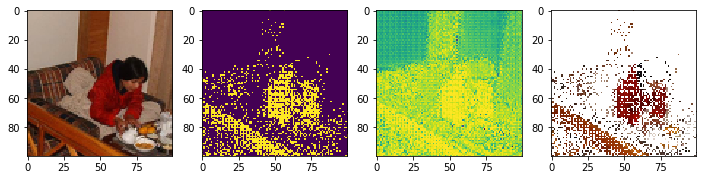

In [16]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))[0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = cvmade.image.image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()
        
unet.load_state_dict(torch.load("checkpoint-noaug.pth.tar"))
        
print("Trainset")
show_segmentations(unet, trainset)

print("Valset")
show_segmentations(unet, valset)

# Augmenation

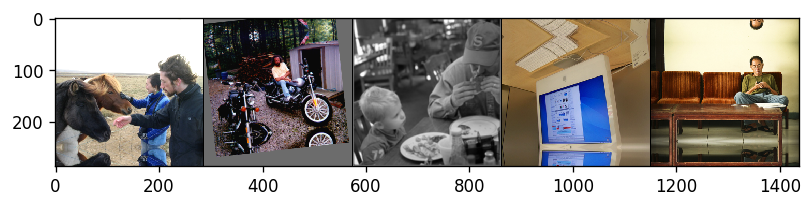

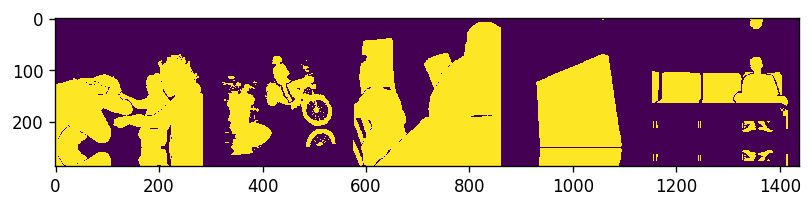

In [17]:
trainset_augmented = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                                multiclass=MULTICLASS, train=True, augment=True)
show_dataset(trainset_augmented)

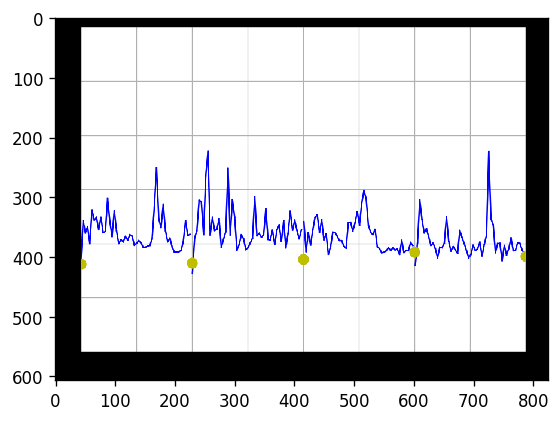

In [18]:
loss_fn = BCELoss if NUM_CLASSES == 2 else XentLoss
unet.load_state_dict(torch.load("checkpoint-noaug.pth.tar"))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    trainset.set_padding(unet.padding)
    valset.set_padding(unet.padding)
    seminar.train_model(unet, loss_fn, make_optimizer, trainset_augmented, valset,
                        lr_scheduler_fn=lambda optimizer: None,
                        n_iters=2000,
                        eval_steps=500,
                        batch_size=4,
                        num_workers=8,
                        init=False,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/01-1-aug.png")

In [19]:
#torch.save(unet.state_dict(), "checkpoint-aug.pth.tar")

Trainset


<Figure size 960x720 with 0 Axes>

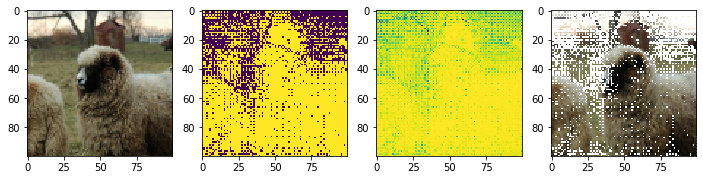

<Figure size 960x720 with 0 Axes>

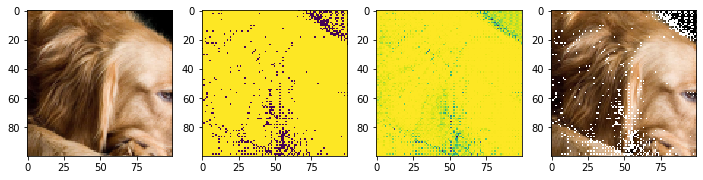

<Figure size 960x720 with 0 Axes>

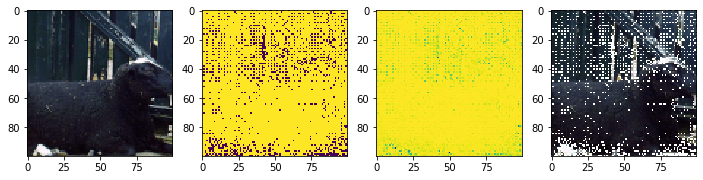

<Figure size 960x720 with 0 Axes>

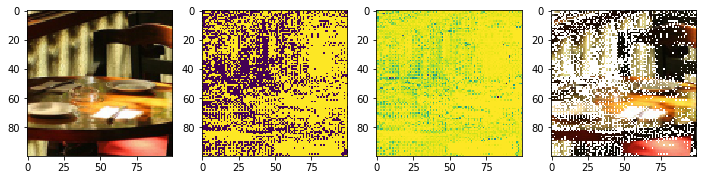

<Figure size 960x720 with 0 Axes>

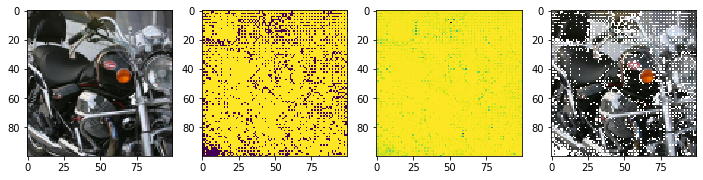

Valset


<Figure size 960x720 with 0 Axes>

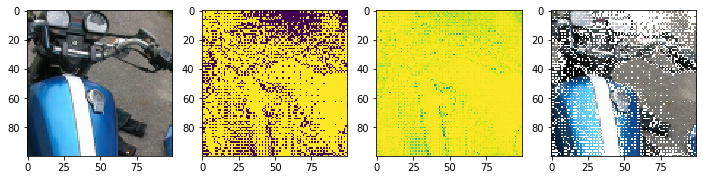

<Figure size 960x720 with 0 Axes>

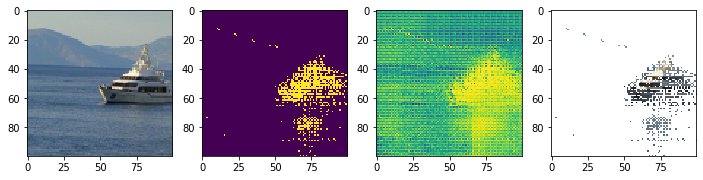

<Figure size 960x720 with 0 Axes>

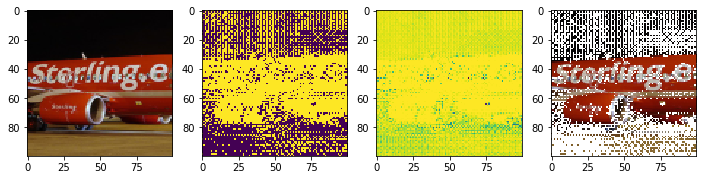

<Figure size 960x720 with 0 Axes>

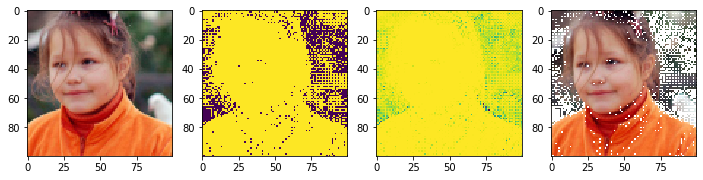

<Figure size 960x720 with 0 Axes>

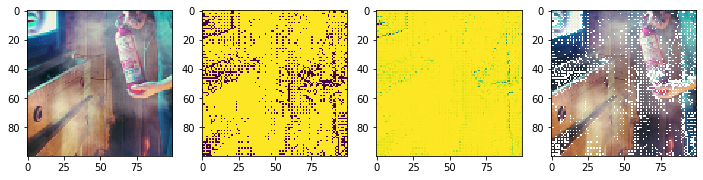

In [20]:
unet.load_state_dict(torch.load("checkpoint-aug.pth.tar"))

print("Trainset")
show_segmentations(unet, trainset)

print("Valset")
show_segmentations(unet, valset)